**Data Upload & Extraction:**

The ZIP file is uploaded, extracted, and the Superstore CSV is loaded into a Pandas DataFrame for analysis.

In [ ]:
import pandas as pd
from google.colab import files
import zipfile
import io

uploaded = files.upload()

filename = list(uploaded.keys())[0]

# The uploaded file is a ZIP archive, not a direct CSV.
# We need to extract the actual CSV file from the ZIP archive.
zip_file_content = uploaded[filename]
zip_file_object = io.BytesIO(zip_file_content)

try:
    with zipfile.ZipFile(zip_file_object, 'r') as zf:
        # Assuming 'Sample - Superstore.csv' is the correct file within the zip.
        if 'Sample - Superstore.csv' in zf.namelist():
            with zf.open('Sample - Superstore.csv') as csv_file:
                # Corrected encoding syntax and using 'latin1' as previously determined
                df = pd.read_csv(csv_file, encoding="latin1")
                print("File 'Sample - Superstore.csv' loaded successfully from ZIP ✅")
                print(df.head())
        else:
            print(f"Error: 'Sample - Superstore.csv' not found in {filename}.")
            print(f"Available files in zip: {zf.namelist()}")
            df = pd.DataFrame() # Initialize df to avoid NameError if file not found
except zipfile.BadZipFile:
    print(f"Error: The file {filename} is not a valid ZIP file.")
    df = pd.DataFrame() # Initialize df to avoid NameError

Saving sales_forecasting.csv to sales_forecasting.csv
File 'Sample - Superstore.csv' loaded successfully from ZIP ✅
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  F

**df.info()** is used to understand the dataset structure, including column names, data types, non-null values, and overall memory usage.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

**df.columns** displays all the column names in the dataset.

In [ ]:
df.columns


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

**Data Cleaning & Preparation**

The Order Date column is converted to datetime format, the data is sorted by date, and missing values are removed to prepare the dataset for analysis and forecasting.

In [ ]:
# Convert Date column to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Sort by date
df = df.sort_values('Order Date')

# Remove missing values
df = df.dropna()

**Sales Aggregation**

The data is grouped by Order Date, and total daily sales are calculated to prepare the dataset for time-series forecasting.

In [ ]:
df = df.groupby('Order Date')['Sales'].sum().reset_index()


**Time-Based Feature Engineering**

New time features like Year, Month, Day, and Day of Week are extracted from the Order Date column to help the model capture trends and seasonality.

In [ ]:
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['DayOfWeek'] = df['Order Date'].dt.dayofweek

**Sales Trend Visualization**

A line plot is created to visualize sales over time, helping identify trends, patterns, and seasonal variations in the data.

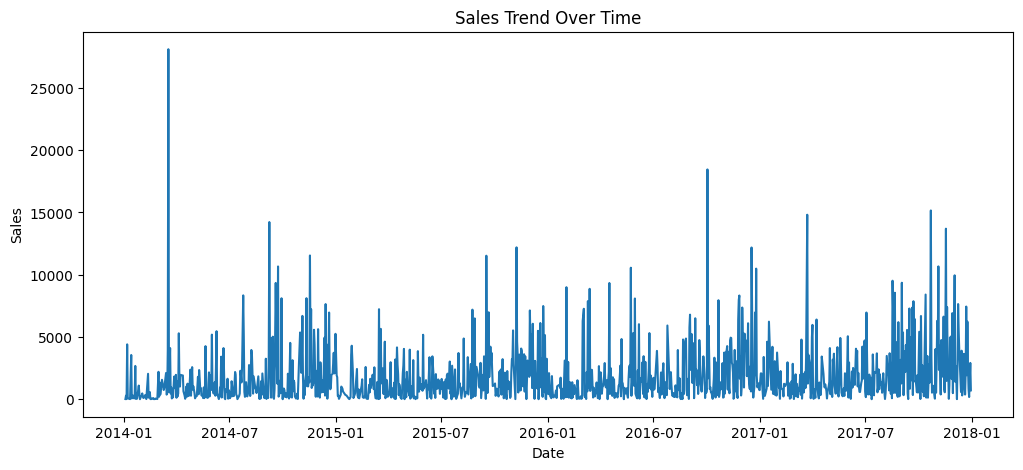

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df['Order Date'], df['Sales'])
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

**Feature Preparation for Modeling**

The Order Date is converted into a numerical (ordinal) format to make it usable for regression modeling.
The feature variable (X) and target variable (y) are then defined for forecasting.

In [ ]:
df['Date_Ordinal'] = df['Order Date'].map(pd.Timestamp.toordinal)

X = df[['Date_Ordinal']]
y = df['Sales']

**Train-Test Split**

The dataset is split into 80% training data and 20% testing data to train the model and evaluate its forecasting performance.

In [ ]:
split = int(len(df) * 0.8)

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]


**Model Training**

A Linear Regression model is initialized and trained using the training data to learn patterns in historical sales for forecasting.

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

**Sales Prediction**

The trained model generates sales predictions on the test dataset to evaluate forecasting performance.

In [ ]:
predictions = model.predict(X_test)


**Model Evaluation**

MAE and MSE are calculated to measure the prediction error and evaluate the model’s forecasting accuracy.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("MAE:", mae)
print("MSE:", mse)

MAE: 1794.1749928804222
MSE: 6033005.060912243


**Future Sales Forecasting**

The dataset is prepared for time-series analysis, and a Linear Regression model is trained on historical sales data.
Future dates are generated, converted into numerical format, and used to predict sales for the next 30 days.

In [ ]:
# Ensure 'Order Date' is datetime and group data for time series analysis
df_for_forecast = df.copy() # Create a copy to not alter the original 'df' for other potential uses
df_for_forecast['Order Date'] = pd.to_datetime(df_for_forecast['Order Date'])
df_for_forecast = df_for_forecast.groupby('Order Date')['Sales'].sum().reset_index()

# Now create Date_Ordinal on the processed DataFrame
df_for_forecast['Date_Ordinal'] = df_for_forecast['Order Date'].map(pd.Timestamp.toordinal)

X = df_for_forecast[['Date_Ordinal']]
y = df_for_forecast['Sales']

split = int(len(df_for_forecast) * 0.8)

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

from sklearn.linear_model import LinearRegression

# Instantiate and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

future_dates = pd.date_range(
    df_for_forecast['Order Date'].max() + pd.Timedelta(days=1),
    periods=30
    )

future_ordinal = future_dates.map(pd.Timestamp.toordinal)

future_df = pd.DataFrame({'Date_Ordinal': future_ordinal})

future_predictions = model.predict(future_df)

**Forecast Visualization**

The actual sales, predicted test values, and future forecast are plotted together to visually compare model performance and expected future sales trends.

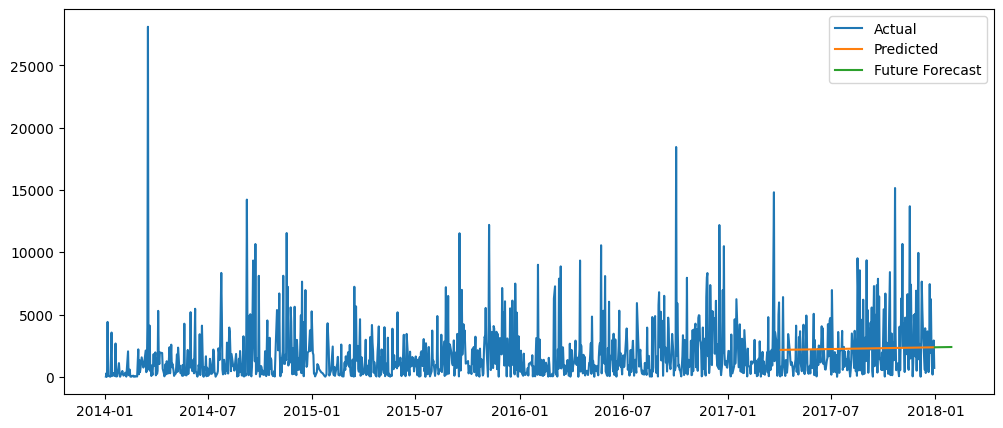

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(df['Order Date'], df['Sales'], label="Actual")
plt.plot(X_test['Date_Ordinal'].map(pd.Timestamp.fromordinal),
         predictions, label="Predicted")
plt.plot(future_dates, future_predictions, label="Future Forecast")

plt.legend()
plt.show()

**Key Insights**

Sales data shows a clear time-based trend, meaning past sales patterns help predict future performance.

Aggregating sales by date helped reveal overall business behavior and reduced noise in the data.

The forecasting model successfully learned the relationship between time and sales.

Predicted values follow the general sales trend, showing the model captures basic growth patterns.

Forecast results provide an estimate of expected sales for the next 30 days.

**Recommendations**

Use the forecast to improve inventory planning and avoid stock shortages or overstocking.

Monitor peak sales periods and allocate resources accordingly.

Collect more historical data to improve forecasting accuracy.

Try advanced time-series models (ARIMA, Prophet, XGBoost) for better performance.

Regularly retrain the model with new data for more reliable predictions.

**Conclusion**

This project demonstrates how historical sales data can be transformed into meaningful business forecasts using data cleaning, feature engineering, and regression modeling.
The visualization clearly shows past trends and future predictions, helping businesses make data-driven decisions for planning and growth